In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import pandas as pd
%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 10]


In [2]:
stars = pd.read_csv('stars')
circles = pd.read_csv('circles')

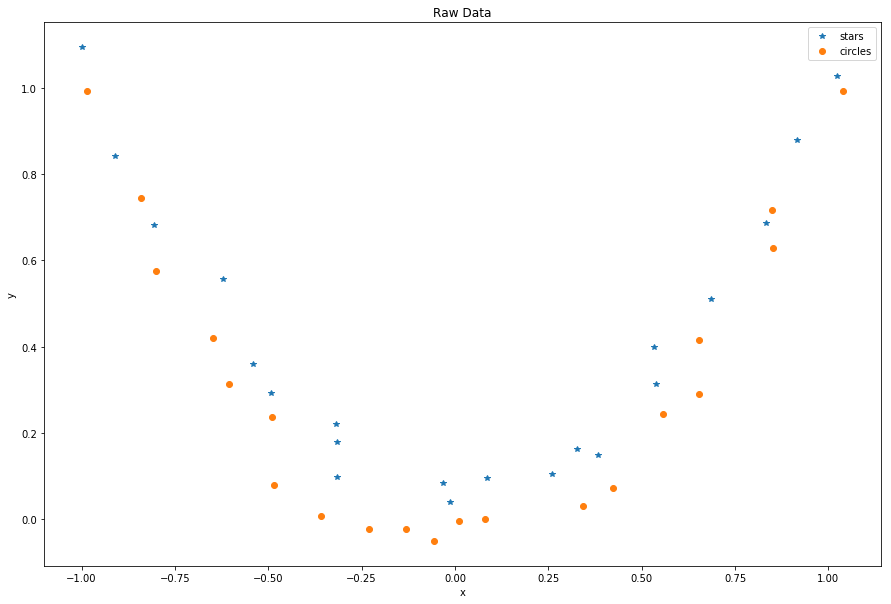

In [3]:
plt.plot(stars.x, stars.y, '*')
plt.plot(circles.x, circles.y, 'o')
plt.title('Raw Data'); plt.xlabel('x'); plt.ylabel('y'); plt.legend(['stars', 'circles']);

In [4]:
# Join the data

def make_dataframe():
    columns = "x y label".split()
    stars['label'] = 1
    circles['label'] = -1
    data = pd.concat([stars, circles], ignore_index=True)
    data['coef'] = np.nan
    return data
    
data = make_dataframe()

In [25]:
def gaussian_kernel(x, z, h):
    return math.exp((-1.0/h) * ((x[0]-z[0])**2 + (x[1]-z[1])**2))
    
def build_matrix_K(data, h):
    K = np.zeros([len(data),len(data)])

    for i, row in data.iterrows():
        X = [row.x, row.y]
        for j, z in data.iterrows():
            Z = [z.x, z.y]
            K[i][j] = gaussian_kernel(X, Z, h)
    return K 
        
    

def phi_function(X, h, data, K):
    out = 0
    for idx, row in data.iterrows():
        Z = [row.x, row.y]
        out += row.coef * gaussian_kernel(X, Z, h)
    return out


def solve_derivative(data, lamb, K):
    Q = np.array(data['label'])
    I = np.identity(len(data))
    return np.matmul(Q, np.linalg.inv(K+lamb*I))


def solve_coefs(h, lamb, data, K):
    A = solve_derivative(data, lamb, K)
    data['coef'] = A
    return data

def plot_point_cloud(dimensions, lamb, h, K, data, filename):
    dummy_dim = dimensions
    dummy_x = np.linspace(-1, 1.25, dummy_dim)
    dummy_y = np.linspace(-0.2, 1.5, dummy_dim)
    boundary = []

    df = pd.DataFrame(columns='x y phi'.split())
    bigX = np.array([])
    bigY = np.array([])

    for i in range(dummy_dim):
        for j in range(dummy_dim):
            bigX = np.append(bigX, dummy_x[i])
            bigY = np.append(bigY, dummy_y[j])

    df['x'] = bigX
    df['y'] = bigY
    df['phi'] = np.nan

    prev_phi = np.nan
    prev_X = np.nan
    
    skip = False
    for i, row in df.iterrows():
        X = [row.x, row.y]
        phi = phi_function(X, h, data, K)
        df['phi'][i] = phi
        
        # Very ugly fix. Pls do not judge me 
        if (prev_phi < 0 and phi > 0) or (prev_phi > 0 and phi < 0):
            if not skip: 
                boundary.append([row.x, np.mean([prev_X[1], X[1]])])
            
            skip = not skip
            
        prev_phi = phi 
        prev_X = X
    
        
    circle_mask = df[df['phi'] < 0]
    star_mask = df[df['phi'] > 0]

    plt.plot(stars.x, stars.y, '*', markersize=10)
    plt.plot(circles.x, circles.y, 'o', markersize=10)

    plt.plot(star_mask.x, star_mask.y, 'ro', alpha=0.1, markersize=10)
    plt.plot(circle_mask.x, circle_mask.y, 'go', alpha=0.1, markersize=10)

    
    boundary_x = [row[0] for row in boundary]
    boundary_y = [row[1] for row in boundary]
    plt.plot(boundary_x, boundary_y, 'k')

    plt.title('Raw Data and Phi Function Decision CloudP, h=' + str(h)+ ', lambda=' + str(lamb)); 
    plt.xlabel('x'); plt.ylabel('y'); plt.legend(['stars', 'circles', 'stars-decision-cloud', 'circles-decision-cloud']);
    plt.savefig(filename + '.png', bbox_inches='tight')
#     plt.close()     
    return boundary    

           x         y  label       coef
0  -0.998552  1.094898      1   6.189391
1  -0.911344  0.842532      1   9.334493
2  -0.806870  0.681422      1   9.522683
3  -0.620037  0.558034      1   2.214058
4  -0.539641  0.360727      1   6.313917
5  -0.492435  0.293439      1   6.611430
6  -0.318373  0.220624      1  -2.653166
7  -0.315935  0.178905      1   0.210547
8  -0.314909  0.098887      1   7.282029
9  -0.032999  0.085088      1   1.108694
10 -0.014446  0.041193      1   7.927607
11  0.084627  0.096876      1   0.348081
12  0.261070  0.105091      1   3.262574
13  0.384269  0.148255      1   5.016712
14  0.325896  0.163938      1  -1.395138
15  0.539325  0.312710      1   6.889459
16  0.533798  0.400019      1   0.350535
17  0.684872  0.511419      1   7.180539
18  0.833134  0.686319      1  10.388707
19  0.916754  0.878652      1   5.162499
20  1.023066  1.026989      1   7.586055
21 -0.985427  0.992956     -1  -9.706669
22 -0.841466  0.745356     -1 -11.731351
23 -0.801054  0.

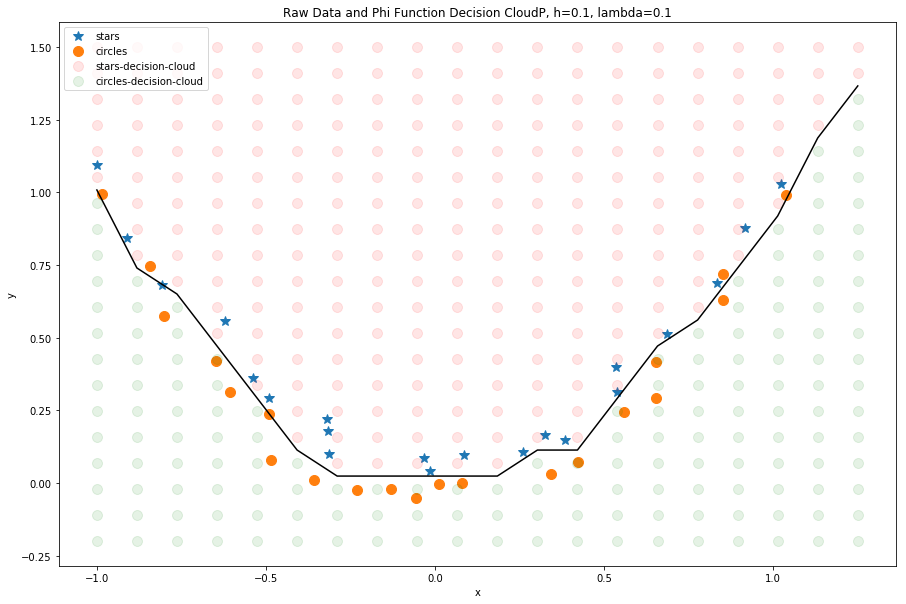

In [33]:
def main(h, lamb, dimension, filename):
    data = make_dataframe()
    K = build_matrix_K(data, h)
    data = solve_coefs(h, lamb, data, K)
    boundary = plot_point_cloud(dimension, lamb, h, K, data, filename)
    print(data)
    
main(h = 0.1, lamb = 0.1, dimension = 20, filename='test')

In [21]:
for h in np.linspace(0.1, 2, 3):
    for l in np.linspace(0.1, 2, 3):
        main(h, l, 75, 'images/h' + str(h) + '-lambda' + str(l))